# Bayesian Network and Experimental Design

# Libraries

In [26]:
import pybbn
import pandas as pd
pd.set_option('display.max_rows', None)
import networkx as nx 
import matplotlib.pyplot as plt
%matplotlib inline
import random
import sys

from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
from pybbn.sampling.sampling import LogicSampler

from scipy.stats import binom
import numpy as np
np.seterr(invalid='ignore')
import plotly
import plotly.io as pio
import chart_studio
import chart_studio.plotly as cspy
import chart_studio.tools as tls
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from urllib.request import urlopen
import json

import seaborn as sns 

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

username = 'vishalgattani' # your username\n",
api_key = 'WSy2EFPTbxYYm3Rmcx53' # your api key - go to profile > settings > regenerate key\n",
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)


# Functions

In [27]:
def getBinomProb(total_exp_runs,p):
    return list(binom.pmf(list(range(total_exp_runs + 1)),total_exp_runs, p))

def evidence(join_tree,ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)
    
def resetEvidence(join_tree):
    join_tree.unobserve_all()
    
def print_probs(join_tree):
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node.to_dict())
        print("Values:")
        print(potential)
        print('----------------')
        
    print("="*90)
        
def print_probs_top_node(join_tree):
    for node in join_tree.get_bbn_nodes():
        if (node.to_dict()['variable']['id']==0):
            potential = join_tree.get_bbn_potential(node)
            df = potential_to_df(join_tree.get_bbn_potential(node))
#             display(df)
            return df
            
def potential_to_df(p):
    data = []
    for pe in p.entries:
        try:
            v = pe.entries.values()[0]
        except:
            v = list(pe.entries.values())[0]
        p = pe.value
        t = (v, p)
        data.append(t)
    return pd.DataFrame(data, columns=['val', 'p'])

def potentials_to_dfs(join_tree):
    data = []
    for node in join_tree.get_bbn_nodes():
        name = node.variable.name
        df = potential_to_df(join_tree.get_bbn_potential(node))
        display(df)
        t = (name, df)
        data.append(t)
    return data

def drawBBN(bbn):
    n, d = bbn.to_nx_graph()
    pos = nx.spring_layout(n)
    nx.draw_spring(n, with_labels=True,labels=d)
    ax = plt.gca()
    
    plt.show()

def plotROC(p,r,fpr_tree, tpr_tree,fpr_lr, tpr_lr,fpr_lrl2, tpr_lrl2,fpr_nb, tpr_nb):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=fpr_tree, y=tpr_tree, mode="markers+lines",name='DT'))
    fig.add_trace(go.Scatter(x=fpr_lr, y=tpr_lr, mode="markers+lines",name='LR'))
    fig.add_trace(go.Scatter(x=fpr_lrl2, y=tpr_lrl2, mode="markers+lines",name='LR(L2)'))
#     fig.add_trace(go.Scatter(x=fpr_nb, y=tpr_nb, mode="markers+lines",name='NB'))
    fig.update_layout(hovermode="x",title='Receiver Operating Characteristic '+"p="+str(p)+",r="+str(r))
    fig.update_xaxes(title_text='TPR')
    fig.update_yaxes(title_text='FPR')
    fig.show()

# Bayesian Network using `pybbn`

In [29]:
threshold_num_runs = 2 # rule
total_exp_runs = 3

p = 0.8
r = 0.01

exp_T = getBinomProb(total_exp_runs,p)
exp_F = getBinomProb(total_exp_runs,r)


exp_dict = {"True":exp_T,"False":exp_F}
exp_cpt = pd.DataFrame(exp_dict)

test_keys = []
test_values = []

for i in range(total_exp_runs+1):
    test_keys.append(str(i))
    if i >= threshold_num_runs:
        test_values.append([1,0])
    else:
        test_values.append([0,1])

test_results_dict = dict(zip(test_keys, test_values))
test_results_cpt = pd.DataFrame(test_results_dict) 
test_results_cpt["States"] = ['Correct','Incorrect']
test_results_cpt.set_index("States",inplace=True)


# Create nodes by manually typing in probabilities
test_results = BbnNode(Variable(0, 'Test Results say it works properly', test_results_cpt.index.values.tolist()), np.ndarray.flatten(test_results_cpt.values.transpose()).tolist())
exp1 = BbnNode(Variable(1, 'Experiment 1 - Successes', test_results_cpt.columns), exp_T+exp_F)
algo = BbnNode(Variable(2, 'Algorithm works correctly', ["True","False"]), [0.5,0.5])

bbn = Bbn() \
    .add_node(algo) \
    .add_node(exp1) \
    .add_node(test_results) \
    .add_edge(Edge(algo, exp1, EdgeType.DIRECTED)) \
    .add_edge(Edge(exp1, test_results, EdgeType.DIRECTED))
join_tree = InferenceController.apply(bbn)

# Plotting the BBN

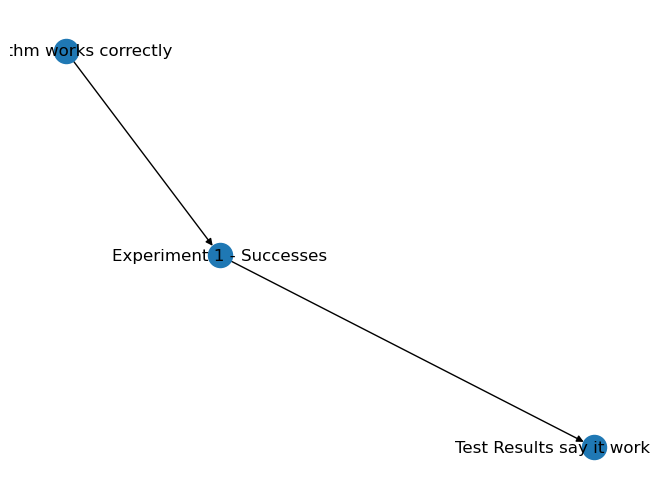

In [30]:
drawBBN(bbn)  

# Printing values of nodes within BBN without setting evidence

In [31]:
print_probs(join_tree)

Node: {'probs': [0.007999999999999995, 0.09600000000000006, 0.384, 0.5120000000000001, 0.970299, 0.029402999999999995, 0.00029699999999999985, 1.0000000000000002e-06], 'variable': {'id': 1, 'name': 'Experiment 1 - Successes', 'values': Index(['0', '1', '2', '3'], dtype='object')}}
Values:
1=0|0.48915
1=1|0.06270
1=2|0.19215
1=3|0.25600
----------------
Node: {'probs': [0, 1, 0, 1, 1, 0, 1, 0], 'variable': {'id': 0, 'name': 'Test Results say it works properly', 'values': ['Correct', 'Incorrect']}}
Values:
0=Correct|0.44815
0=Incorrect|0.55185
----------------
Node: {'probs': [0.5, 0.5], 'variable': {'id': 2, 'name': 'Algorithm works correctly', 'values': ['True', 'False']}}
Values:
2=True|0.50000
2=False|0.50000
----------------


# Setting evidence in BBN

In [32]:
evidence(join_tree,'ev1', 'Algorithm works correctly', 'True', 1.0)
print_probs(join_tree)
df = print_probs_top_node(join_tree)
display(df)
resetEvidence(join_tree)

Node: {'probs': [0.007999999999999995, 0.09600000000000006, 0.384, 0.5120000000000001, 0.970299, 0.029402999999999995, 0.00029699999999999985, 1.0000000000000002e-06], 'variable': {'id': 1, 'name': 'Experiment 1 - Successes', 'values': Index(['0', '1', '2', '3'], dtype='object')}}
Values:
1=0|0.00800
1=1|0.09600
1=2|0.38400
1=3|0.51200
----------------
Node: {'probs': [0, 1, 0, 1, 1, 0, 1, 0], 'variable': {'id': 0, 'name': 'Test Results say it works properly', 'values': ['Correct', 'Incorrect']}}
Values:
0=Correct|0.89600
0=Incorrect|0.10400
----------------
Node: {'probs': [0.5, 0.5], 'variable': {'id': 2, 'name': 'Algorithm works correctly', 'values': ['True', 'False']}}
Values:
2=True|1.00000
2=False|0.00000
----------------


,val,p
0,Correct,0.896
1,Incorrect,0.104


# Generating graphs

- Setting `r` as a fraction of `p`.
- Changing `threshold_num_runs` from `1...n` where `n` is experiment runs.
- Gathering false positives and true positives from the above methods for a certain `p,r` combination.

# False Negatives and False Positives

- False negative (FN): The probability of node “test results say it works properly” is `incorrect` given the node “Algorithm works correctly” is `True`. 

- False Positive (FP): The probability of node “test results say it works properly” is `correct` given the node “Algorithm works correctly” is `False`. 

In [33]:
def getFPTN(join_tree):
    evidence(join_tree,'ev1', 'Algorithm works correctly', 'False', 1.0)
    df = print_probs_top_node(join_tree)
    resetEvidence(join_tree)
    dffp = df[df['val']=='Correct']['p']
    dftn = df[df['val']=='Incorrect']['p']
    return dffp,dftn
    
def getFNTP(join_tree):
    evidence(join_tree,'ev1', 'Algorithm works correctly', 'True', 1.0)
    df = print_probs_top_node(join_tree)
    resetEvidence(join_tree)
    dffn = df[df['val']=='Incorrect']['p']
    dftp = df[df['val']=='Correct']['p']
    return dffn,dftp

In [34]:
threshold_num_runs = 2 # rule
min_exp_runs = 3
max_exp_runs = 4

total_exp_runs_list = list(range(min_exp_runs,max_exp_runs+1))

p_list = list(np.linspace(0,1,11))
proportionality_factor = list(np.linspace(0.1,1,10))

row = []

for total_exp_runs in total_exp_runs_list:
    for threshold_num_runs in range(1,total_exp_runs+1):
        for k in proportionality_factor:
            for p in p_list:
                r = k*p
#                 print("p(successful run|algo = T):",p)
#                 print("p(successful run|algo = F):",r," r = ",k,"*","p")
                exp_T = getBinomProb(total_exp_runs,p)
                exp_F = getBinomProb(total_exp_runs,r)
                exp_dict = {"True":exp_T,"False":exp_F}
                exp_cpt = pd.DataFrame(exp_dict)
                test_keys = []
                test_values = []

                for i in range(total_exp_runs+1):
                    test_keys.append(str(i))
                    if i >= threshold_num_runs:
                        test_values.append([1,0])
                    else:
                        test_values.append([0,1])

                test_results_dict = dict(zip(test_keys, test_values))
                test_results_cpt = pd.DataFrame(test_results_dict) 
                test_results_cpt["States"] = ['Correct','Incorrect']
                test_results_cpt.set_index("States",inplace=True)


                # Create nodes by manually typing in probabilities
                test_results = BbnNode(Variable(0, 'Test Results say it works properly', test_results_cpt.index.values.tolist()), np.ndarray.flatten(test_results_cpt.values.transpose()).tolist())
                exp1 = BbnNode(Variable(1, 'Experiment 1 - Successes', test_results_cpt.columns), exp_T+exp_F)
                algo = BbnNode(Variable(2, 'Algorithm works correctly', ["True","False"]), [0.5,0.5])

                bbn = Bbn() \
                    .add_node(algo) \
                    .add_node(exp1) \
                    .add_node(test_results) \
                    .add_edge(Edge(algo, exp1, EdgeType.DIRECTED)) \
                    .add_edge(Edge(exp1, test_results, EdgeType.DIRECTED))

                join_tree = InferenceController.apply(bbn)

                dffp,dftn = getFPTN(join_tree)
                dffn,dftp = getFNTP(join_tree)
                
#                 print("FP : P(Test=T|Algo=F)=",dffp.tolist())
#                 print("TN : P(Test=F|Algo=F)=",dftn.tolist())
#                 print("FN : P(Test=F|Algo=T)=",dffn.tolist())
#                 print("TP : P(Test=T|Algo=T)=",dftp.tolist())

                fp = dffp.tolist()[0]
                tn = dftn.tolist()[0]
                fn = dffn.tolist()[0]
                tp = dftp.tolist()[0]

                data = [total_exp_runs,threshold_num_runs,p,r,fp,tn,fn,tp]
                row.append(data)
#                 print("+"*80)
                
    checkdf = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
#     display(checkdf)
    
df = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
# display(df)    


02/28/2023

# TP vs FP

Plotting the `True Positive` vs `False Positive` while varying `p`,`r` and `threshold_exp`.

In [35]:
dfs = df.groupby(['n_exp','threshold_exp'])
    
fig = go.Figure()
for i in dfs:
    i[1]['groups'] = np.floor_divide(i[1].index, len(p_list)).astype(str)
#     print(i[1]['groups'].values.tolist())
    i[1]['k'] = i[1]['groups'].apply(lambda d: proportionality_factor[int(d)%len(proportionality_factor)])
#     display(i[1])
    i[1]['threshold_exp'] = i[1]['threshold_exp'].astype('string')
    fig = px.line(i[1], x="fp", y="tp", hover_data=['n_exp','threshold_exp','p','r'],color='k',markers=True)
    fig.update_layout(title_text="{Number of experiments:"+str(i[1]['n_exp'].unique()[0])+"}{Threshold Runs:"+str(i[1]['threshold_exp'].unique()[0])+"}")
    fig.show()


# Observations

- As the threshold for number of experiments (`threshold_exp`) increases, the `false positive` rate decreases. This is intuitive as it is less probable that the node `Test Results say it works properly` states `correct` when `Algorithm works properly` is `false.
- When the proportionality constant `k` in the equation `r=k*p` is high, the `True Positive` vs `False Positive` becomes a linear relationship. It is also the case when `Number of experiments` equals the threshold for number of experiments considered for the success of the test.

03/01/2023
- Pick a particular combination of (p, r), where p is large but less than 1, and r is small (but not too small), and see how the P{TP} and P{FP} change as a function of the number of tests and the threshold.

In [38]:
threshold_num_runs = 2 # rule
min_exp_runs = 3
max_exp_runs = 15

total_exp_runs_list = list(range(min_exp_runs,max_exp_runs+1))

p_list = [0.9]

row = []

for total_exp_runs in total_exp_runs_list:
    for threshold_num_runs in range(1,total_exp_runs+1):
            for p in p_list:
                r = 0.4
#                 print("p(successful run|algo = T):",p)
#                 print("p(successful run|algo = F):",r," r = ",k,"*","p")
                exp_T = getBinomProb(total_exp_runs,p)
                exp_F = getBinomProb(total_exp_runs,r)
                exp_dict = {"True":exp_T,"False":exp_F}
                exp_cpt = pd.DataFrame(exp_dict)
                test_keys = []
                test_values = []

                for i in range(total_exp_runs+1):
                    test_keys.append(str(i))
                    if i >= threshold_num_runs:
                        test_values.append([1,0])
                    else:
                        test_values.append([0,1])

                test_results_dict = dict(zip(test_keys, test_values))
                test_results_cpt = pd.DataFrame(test_results_dict) 
                test_results_cpt["States"] = ['Correct','Incorrect']
                test_results_cpt.set_index("States",inplace=True)


                # Create nodes by manually typing in probabilities
                test_results = BbnNode(Variable(0, 'Test Results say it works properly', test_results_cpt.index.values.tolist()), np.ndarray.flatten(test_results_cpt.values.transpose()).tolist())
                exp1 = BbnNode(Variable(1, 'Experiment 1 - Successes', test_results_cpt.columns), exp_T+exp_F)
                algo = BbnNode(Variable(2, 'Algorithm works correctly', ["True","False"]), [0.5,0.5])

                bbn = Bbn() \
                    .add_node(algo) \
                    .add_node(exp1) \
                    .add_node(test_results) \
                    .add_edge(Edge(algo, exp1, EdgeType.DIRECTED)) \
                    .add_edge(Edge(exp1, test_results, EdgeType.DIRECTED))

                join_tree = InferenceController.apply(bbn)

                dffp,dftn = getFPTN(join_tree)
                dffn,dftp = getFNTP(join_tree)
                
#                 print("FP : P(Test=T|Algo=F)=",dffp.tolist())
#                 print("TN : P(Test=F|Algo=F)=",dftn.tolist())
#                 print("FN : P(Test=F|Algo=T)=",dffn.tolist())
#                 print("TP : P(Test=T|Algo=T)=",dftp.tolist())

                fp = dffp.tolist()[0]
                tn = dftn.tolist()[0]
                fn = dffn.tolist()[0]
                tp = dftp.tolist()[0]

                data = [total_exp_runs,threshold_num_runs,p,r,fp,tn,fn,tp]
                row.append(data)
#                 print("+"*80)
                
    checkdf = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
#     display(checkdf)
    
df = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
# display(df.head())    


# Trend of `FP` and `TP` as `n_exp` increases with fixed `threshold_exp`

# Number of experiments vs Threshold Runs 

In [24]:
fig = go.Figure()
fig = px.line(df, x="fp", y="tp", hover_data=['n_exp','threshold_exp','p','r'],color='n_exp',markers=True)
fig.update_layout(title_text="{Number of experiments vs Threshold Runs at (p,r):{"+str(p)+","+str(r)+"}")
fig.show()

# Observations

- For `n_exp = 7`, when the `threshold_exp` is either `5` or `6`:
    - `tp` is 0.974 and 0.85 respectively. 
    - `fp` is 0.096 and 0.0085 respectively.
- For `n_exp = 8`, when the `threshold_exp` is `6`:
    - `tp` is 0.9619.
    - `fp` is 0.049.

As number of experiments to be performed increases, the curves become steeper as `threshold_exp` increases and the `tp` values decreases. `fp` values increase as `threshold_exp` decrease.

In [48]:
dfs = df.groupby(['n_exp'])   
fig = go.Figure()
for i in dfs:
    display(i[1])
    fig = go.Figure()
    fig = px.line(i[1], x="fp", y="tp",text='threshold_exp',hover_data=['n_exp','threshold_exp','p','r'],color='n_exp',markers=True)
    fig.update_traces(textposition='top center')
    fig.update_layout(title_text="{Number of experiments vs Threshold Runs at (p,r):{"+str(p)+","+str(r)+"}")
    fig.show()

'A'

,n_exp,threshold_exp,p,r,fp,tn,fn,tp
0,3,1,0.9,0.4,0.784,0.216,0.001,0.999
1,3,2,0.9,0.4,0.352,0.648,0.028,0.972
2,3,3,0.9,0.4,0.064,0.936,0.271,0.729


'A'

,n_exp,threshold_exp,p,r,fp,tn,fn,tp
3,4,1,0.9,0.4,0.8704,0.1296,0.0001,0.9999
4,4,2,0.9,0.4,0.5248,0.4752,0.0037,0.9963
5,4,3,0.9,0.4,0.1792,0.8208,0.0523,0.9477
6,4,4,0.9,0.4,0.0256,0.9744,0.3439,0.6561


'A'

,n_exp,threshold_exp,p,r,fp,tn,fn,tp
7,5,1,0.9,0.4,0.92224,0.07776,0.00001,0.99999
8,5,2,0.9,0.4,0.66304,0.33696,0.00046,0.99954
9,5,3,0.9,0.4,0.31744,0.68256,0.00856,0.99144
10,5,4,0.9,0.4,0.08704,0.91296,0.08146,0.91854
11,5,5,0.9,0.4,0.01024,0.98976,0.40951,0.59049


'A'

,n_exp,threshold_exp,p,r,fp,tn,fn,tp
12,6,1,0.9,0.4,0.953344,0.046656,1.000000e-06,0.999999
13,6,2,0.9,0.4,0.766720,0.233280,5.500000e-05,0.999945
14,6,3,0.9,0.4,0.455680,0.544320,1.270000e-03,0.998730
15,6,4,0.9,0.4,0.179200,0.820800,1.585000e-02,0.984150
16,6,5,0.9,0.4,0.040960,0.959040,1.142650e-01,0.885735
17,6,6,0.9,0.4,0.004096,0.995904,4.685590e-01,0.531441


'A'

,n_exp,threshold_exp,p,r,fp,tn,fn,tp
18,7,1,0.9,0.4,0.972006,0.027994,1.000000e-07,1.000000
19,7,2,0.9,0.4,0.841370,0.158630,6.400000e-06,0.999994
20,7,3,0.9,0.4,0.580096,0.419904,1.765000e-04,0.999823
21,7,4,0.9,0.4,0.289792,0.710208,2.728000e-03,0.997272
22,7,5,0.9,0.4,0.096256,0.903744,2.569150e-02,0.974309
23,7,6,0.9,0.4,0.018842,0.981158,1.496944e-01,0.850306
24,7,7,0.9,0.4,0.001638,0.998362,5.217031e-01,0.478297


'A'

,n_exp,threshold_exp,p,r,fp,tn,fn,tp
25,8,1,0.9,0.4,0.983204,0.016796,1.000000e-08,1.000000
26,8,2,0.9,0.4,0.893624,0.106376,7.300000e-07,0.999999
27,8,3,0.9,0.4,0.684605,0.315395,2.341000e-05,0.999977
28,8,4,0.9,0.4,0.405914,0.594086,4.316500e-04,0.999568
29,8,5,0.9,0.4,0.173670,0.826330,5.024350e-03,0.994976
30,8,6,0.9,0.4,0.049807,0.950193,3.809179e-02,0.961908
31,8,7,0.9,0.4,0.008520,0.991480,1.868953e-01,0.813105
32,8,8,0.9,0.4,0.000655,0.999345,5.695328e-01,0.430467


'A'

,n_exp,threshold_exp,p,r,fp,tn,fn,tp
33,9,1,0.9,0.4,0.989922,0.010078,1.000000e-09,1.000000
34,9,2,0.9,0.4,0.929456,0.070544,8.200000e-08,1.000000
35,9,3,0.9,0.4,0.768213,0.231787,2.998000e-06,0.999997
36,9,4,0.9,0.4,0.517390,0.482610,6.423400e-05,0.999936
37,9,5,0.9,0.4,0.266568,0.733432,8.909200e-04,0.999109
38,9,6,0.9,0.4,0.099353,0.900647,8.331094e-03,0.991669
39,9,7,0.9,0.4,0.025035,0.974965,5.297214e-02,0.947028
40,9,8,0.9,0.4,0.003801,0.996199,2.251590e-01,0.774841
41,9,9,0.9,0.4,0.000262,0.999738,6.125795e-01,0.387420


'A'

,n_exp,threshold_exp,p,r,fp,tn,fn,tp
42,10,1,0.9,0.4,0.993953,0.006047,1.000000e-10,1.000000
43,10,2,0.9,0.4,0.953643,0.046357,9.100000e-09,1.000000
44,10,3,0.9,0.4,0.832710,0.167290,3.736000e-07,1.000000
45,10,4,0.9,0.4,0.617719,0.382281,9.121600e-06,0.999991
46,10,5,0.9,0.4,0.366897,0.633103,1.469026e-04,0.999853
47,10,6,0.9,0.4,0.166239,0.833761,1.634937e-03,0.998365
48,10,7,0.9,0.4,0.054762,0.945238,1.279520e-02,0.987205
49,10,8,0.9,0.4,0.012295,0.987705,7.019083e-02,0.929809
50,10,9,0.9,0.4,0.001678,0.998322,2.639011e-01,0.736099
51,10,10,0.9,0.4,0.000105,0.999895,6.513216e-01,0.348678


'A'

,n_exp,threshold_exp,p,r,fp,tn,fn,tp
52,11,1,0.9,0.4,0.996372,0.003628,1.000000e-11,1.000000
53,11,2,0.9,0.4,0.969767,0.030233,1.000000e-09,1.000000
54,11,3,0.9,0.4,0.881083,0.118917,4.555000e-08,1.000000
55,11,4,0.9,0.4,0.703716,0.296284,1.248400e-06,0.999999
56,11,5,0.9,0.4,0.467226,0.532774,2.289970e-05,0.999977
57,11,6,0.9,0.4,0.246502,0.753498,2.957061e-04,0.999704
58,11,7,0.9,0.4,0.099353,0.900647,2.750963e-03,0.997249
59,11,8,0.9,0.4,0.029281,0.970719,1.853476e-02,0.981465
60,11,9,0.9,0.4,0.005924,0.994076,8.956185e-02,0.910438
61,11,10,0.9,0.4,0.000734,0.999266,3.026431e-01,0.697357


'A'

,n_exp,threshold_exp,p,r,fp,tn,fn,tp
63,12,1,0.9,0.4,0.997823,0.002177,1.000000e-12,1.000000
64,12,2,0.9,0.4,0.980409,0.019591,1.090000e-10,1.000000
65,12,3,0.9,0.4,0.916557,0.083443,5.455000e-09,1.000000
66,12,4,0.9,0.4,0.774663,0.225337,1.658350e-07,1.000000
67,12,5,0.9,0.4,0.561822,0.438178,3.413530e-06,0.999997
68,12,6,0.9,0.4,0.334791,0.665209,5.018034e-05,0.999950
69,12,7,0.9,0.4,0.158212,0.841788,5.412318e-04,0.999459
70,12,8,0.9,0.4,0.057310,0.942690,4.329343e-03,0.995671
71,12,9,0.9,0.4,0.015267,0.984733,2.563747e-02,0.974363
72,12,10,0.9,0.4,0.002810,0.997190,1.108700e-01,0.889130


'A'

,n_exp,threshold_exp,p,r,fp,tn,fn,tp
75,13,1,0.9,0.4,0.998694,0.001306,1.000000e-13,1.000000
76,13,2,0.9,0.4,0.987375,0.012625,1.180000e-11,1.000000
77,13,3,0.9,0.4,0.942098,0.057902,6.436000e-10,1.000000
78,13,4,0.9,0.4,0.831420,0.168580,2.149300e-08,1.000000
79,13,5,0.9,0.4,0.646958,0.353042,4.906045e-07,1.000000
80,13,6,0.9,0.4,0.425604,0.574396,8.090211e-06,0.999992
81,13,7,0.9,0.4,0.228844,0.771156,9.928549e-05,0.999901
82,13,8,0.9,0.4,0.097671,0.902329,9.200430e-04,0.999080
83,13,9,0.9,0.4,0.032084,0.967916,6.460156e-03,0.993540
84,13,10,0.9,0.4,0.007793,0.992207,3.416072e-02,0.965839


'A'

,n_exp,threshold_exp,p,r,fp,tn,fn,tp
88,14,1,0.9,0.4,0.999216,0.000784,1.000000e-14,1.000000
89,14,2,0.9,0.4,0.991902,0.008098,1.270000e-12,1.000000
90,14,3,0.9,0.4,0.960208,0.039792,7.498000e-11,1.000000
91,14,4,0.9,0.4,0.875691,0.124309,2.728540e-09,1.000000
92,14,5,0.9,0.4,0.720743,0.279257,6.840415e-08,1.000000
93,14,6,0.9,0.4,0.514145,0.485855,1.250565e-06,0.999999
94,14,7,0.9,0.4,0.307548,0.692452,1.720974e-05,0.999983
95,14,8,0.9,0.4,0.150140,0.849860,1.813612e-04,0.999819
96,14,9,0.9,0.4,0.058319,0.941681,1.474054e-03,0.998526
97,14,10,0.9,0.4,0.017510,0.982490,9.230212e-03,0.990770


'A'

,n_exp,threshold_exp,p,r,fp,tn,fn,tp
102,15,1,0.9,0.4,0.999530,0.000470,1.000000e-15,1.000000
103,15,2,0.9,0.4,0.994828,0.005172,1.360000e-13,1.000000
104,15,3,0.9,0.4,0.972886,0.027114,8.641000e-12,1.000000
105,15,4,0.9,0.4,0.909498,0.090502,3.403360e-10,1.000000
106,15,5,0.9,0.4,0.782722,0.217278,9.296101e-09,1.000000
107,15,6,0.9,0.4,0.596784,0.403216,1.866202e-07,1.000000
108,15,7,0.9,0.4,0.390187,0.609813,2.846482e-06,0.999997
109,15,8,0.9,0.4,0.213103,0.786897,3.362489e-05,0.999966
110,15,9,0.9,0.4,0.095047,0.904953,3.106305e-04,0.999689
111,15,10,0.9,0.4,0.033833,0.966167,2.249670e-03,0.997750
